# 3D Reconstruction
Now that we have the silhuettes we can now extract the visual hull of the object. Do so we need the camera intrinsic parameters and the extrinsic paramters. Our simulation pipeline already provides us with a json file for that. A python script then can be ran to extract the camera intrinsics

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src.camera_data import CamerasData
from src.scans import Scans
from src.mesh import build_mesh

## 1. Data Classes
To do the reconstruction we need to organize our data into clear but usefull classes. This will include our Camera Data (`CameraData`) and our Pictures (`Scans`)

### 1.1. Camera Data
For the reconstruction we need:
- Camera Intrinsics
- Extrinsics Parameters

The camera intrinsics are defined by the matrix K and the extrinsics are defined by the individual camera positions (4x4 matrix). All of this is managed by the class ```CameraData```

In [87]:
camera_data = CamerasData("../blender_simulator/simulated_frames/dataset_d30/camera_intrinsics.json", "../blender_simulator/simulated_frames/dataset_d30/transforms_train.json")

In [14]:
print(f"K Matrix:\n{camera_data.K}\n")
print(f'Extrinsic Matrix of Camera 0\n{camera_data.get_camera_extrinsics(0)}\n')
print(f'With shape: {camera_data.extrinsics_array.shape}')

K Matrix:
[[5.0e-02 0.0e+00 9.6e+02]
 [0.0e+00 5.0e-02 5.4e+02]
 [0.0e+00 0.0e+00 1.0e+00]]

Extrinsic Matrix of Camera 0
[[ 9.99992847e-01  5.45056282e-05  3.79700959e-03  0.00000000e+00]
 [ 3.79740074e-03 -1.43533014e-02 -9.99889851e-01 -1.00000000e+00]
 [-3.63797881e-12  9.99897003e-01 -1.43534066e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

With shape: (12, 4, 4)


**Projection Matrix**<br>
By combining both matrices we can have the projection matrix

In [4]:
P = camera_data.P(0)

print(f'Projection Matyrix of Camera 0\n{P}\n')
print(f'With shape: {P.shape}')

Projection Matyrix of Camera 0
[[ 4.99996424e+01  9.59903848e+02 -1.35894199e+01  0.00000000e+00]
 [ 1.89870035e-01  5.39226717e+02 -5.77453321e+01 -5.00000000e+01]
 [-3.63797881e-12  9.99897003e-01 -1.43534066e-02  0.00000000e+00]]

With shape: (3, 4)


## 1.2 Scans
Scans should have all the segemntations from the pictures taken. It holds the data as a binary array [0 or 1]

In [5]:
scans = Scans("../3d_reconstruction/figures/reconstruction_d30/segmented")

Number of scans: 12
Dimension of each scan: (1080, 1920)
Values in the first scan: [0 1]


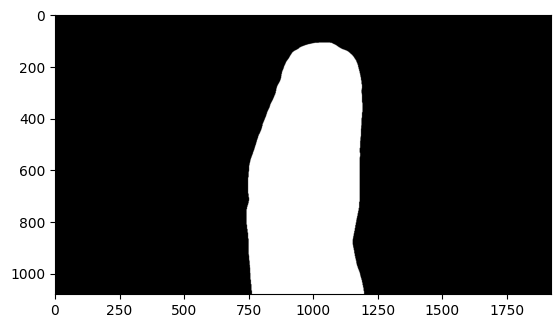

In [9]:
print(f"Number of scans: {scans.nr_positions}")
print(f"Dimension of each scan: {scans.scan_shape}")
print(f"Values in the first scan: {np.unique(scans.scan(0))}")

plt.imshow(scans.scan(0), cmap='gray')

## Convex Hull
This will take the data and apply the convex hull algorithm

K:
 [[2.66667e+03 0.00000e+00 9.60000e+02]
 [0.00000e+00 2.66667e+03 5.40000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]] 

Extrinsics:
 [[ 9.99992847e-01  3.79740074e-03 -3.63797881e-12  3.79740074e-03]
 [ 5.45056282e-05 -1.43533014e-02  9.99897003e-01 -1.43533014e-02]
 [ 3.79700959e-03 -9.99889851e-01 -1.43534066e-02 -9.99889851e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 

P:
 [[ 2.67029e+03 -9.49770e+02 -1.37800e+01 -9.49770e+02]
 [ 2.20000e+00 -5.78220e+02  2.65864e+03 -5.78220e+02]
 [ 0.00000e+00 -1.00000e+00 -1.00000e-02 -1.00000e+00]] 



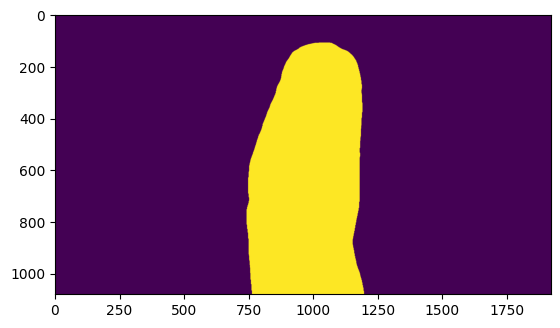

In [104]:
camera_nr = 0

K = camera_data.K
K[1,1] = K[0,0]
middle = np.zeros((3,4)) 
middle[:3, :3] = np.eye(3)
M = camera_data.get_camera_extrinsics(camera_nr)
R = M[:3, :3]
t = M[:3, 3]
R_inv = R.T
t_inv = -R_inv @ t

M_inv2 = np.eye(4)
M_inv2[:3, :3] = R_inv
M_inv2[:3, 3] = t_inv
extrinsics = M_inv2
P = K @ middle @ extrinsics

print("K:\n", np.round(K,2), "\n")
print("Extrinsics:\n", extrinsics, "\n")
print("P:\n", np.round(P,2), "\n")
plt.imshow(scans.scan(0))

In [115]:
x1, x2, x3 = P @ np.array([0,0,0,1])
print(f"X1 : {x1}, X2 : {x2}, X3 : {x3}")
print(x1/x3, x2/x3)

X1 : -949.7678546110789, X2 : -578.2159896691641, X3 : -0.9998898506164551
949.8724824794702 578.2796868201839


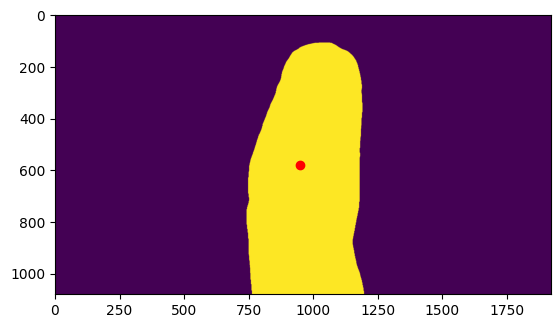

In [116]:
plt.imshow(scans.scan(0))
plt.scatter(x1//x3, x2/x3, color='red')

In [142]:
# GENERATE GRID OF 3D POINTS
resolution = 200
range_value = 0.5
min_val = -range_value
max_val = range_value
x_range = np.linspace(min_val, max_val, resolution)
y_range = np.linspace(min_val, max_val, resolution)
z_range = np.linspace(min_val, max_val, resolution)

X, Y, Z = np.meshgrid(x_range, y_range, z_range)

In [143]:
coord_matrix_map = np.zeros((resolution, resolution, resolution, 3))
coord_matrix_map[:,:,:,0] = X
coord_matrix_map[:,:,:,1] = Y
coord_matrix_map[:,:,:,2] = Z

In [144]:
coord_matrix_map[0,0,0]

array([-0.5, -0.5, -0.5])

In [146]:
camera_volume = np.zeros(X.shape, dtype=int)
for idx, x in enumerate(x_range):
    for idy, y in enumerate(y_range):
        for idz, z in enumerate(z_range):
            point_3d = np.array([x, y, z, 1])

            x1, x2, x3 = np.round(P @ point_3d)
            if x3 == 0: continue
            u = int(x1 / x3)
            v = int(x2 / x3)

            if 0 <= u < scans.scan_shape[0] and 0 <= v < scans.scan_shape[1]:
                camera_volume[idx, idy, idz] += scans.scan(camera_nr)[u, v]
    print(f"Processed x slice {idx+1}/{resolution}", end='\r')

camera_volume = np.where(camera_volume > 0, 1, 0)

In [139]:
camera_volume.shape

(50, 50, 50)

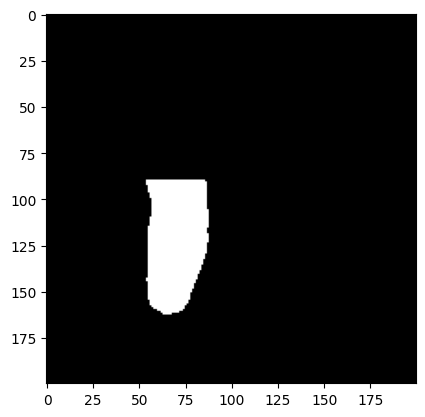

In [148]:
import matplotlib.pyplot as plt
plt.imshow(camera_volume[:, resolution // 2, :], cmap='gray')

In [141]:
build_mesh(camera_volume, file_name="camera_volume_mesh.ply")

✅ Finished exporting blender/camera_volume_mesh.ply
Mesh vertices: 3332, faces: 6608


<trimesh.Trimesh(vertices.shape=(3332, 3), faces.shape=(6608, 3))>

In [52]:
np.linspace(-0.1, 0.1, resolution)

array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
       -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
       -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
       -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
       -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
        0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
        0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
        0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
        0.06326531,  0.06734694,  0.07142857,  0.0755102 ,  0.07959184,
        0.08367347,  0.0877551 ,  0.09183673,  0.09591837,  0.1       ])

In [80]:
results

[array([ -362., -2076.]),
 array([ -362., -2085.]),
 array([ -362., -2094.]),
 array([ -362., -2104.]),
 array([ -362., -2113.]),
 array([ -362., -2122.]),
 array([ -362., -2131.]),
 array([ -362., -2140.]),
 array([ -362., -2150.]),
 array([ -362., -2159.]),
 array([ -362., -2168.]),
 array([ -362., -2177.]),
 array([ -362., -2186.]),
 array([ -362., -2196.]),
 array([ -363., -2205.]),
 array([ -363., -2214.]),
 array([ -363., -2223.]),
 array([ -363., -2233.]),
 array([ -363., -2242.]),
 array([ -363., -2251.]),
 array([ -363., -2260.]),
 array([ -363., -2269.]),
 array([ -363., -2279.]),
 array([ -363., -2288.]),
 array([ -363., -2297.]),
 array([ -363., -2306.]),
 array([ -363., -2315.]),
 array([ -363., -2325.]),
 array([ -363., -2334.]),
 array([ -363., -2343.]),
 array([ -363., -2352.]),
 array([ -363., -2362.]),
 array([ -363., -2371.]),
 array([ -363., -2380.]),
 array([ -363., -2389.]),
 array([ -363., -2398.]),
 array([ -363., -2408.]),
 array([ -363., -2417.]),
 array([ -36

In [81]:
np.array(results).shape

(125000, 2)

In [82]:
np.max(np.unique(results, axis=0))

np.float64(363.0)

In [106]:
Ps = []
for i in range(camera_data.nr_cameras):
    P = camera_data.P(i)
    Ps.append(P)
Ps = np.array(Ps)

In [108]:
def estimate_extent(Ps, image_size, near=0.1, far=2.0):
    W, H = image_size
    corners_2d = np.array([[0,0], [W,0], [0,H], [W,H]])
    pts_world = []

    for P in Ps:
        # camera center (null space of P)
        _, _, Vt = np.linalg.svd(P)
        C = Vt[-1]
        C = C[:3] / C[3]

        # direction vectors for each corner ray
        KRt = P[:, :3]
        dirs = []
        for (u,v) in corners_2d:
            ray_cam = np.linalg.inv(KRt) @ np.array([u, v, 1.0])
            ray_cam /= np.linalg.norm(ray_cam)
            dirs.append(ray_cam)

        dirs = np.stack(dirs)
        # generate near/far points
        for d in dirs:
            pts_world.append(C + d * near)
            pts_world.append(C + d * far)

    pts_world = np.stack(pts_world)
    return pts_world.min(axis=0), pts_world.max(axis=0)


In [109]:
estimate_extent(Ps, scans.scan_shape)

(array([-1.17937123,  0.06638487, -2.18180192]),
 array([1.17907361, 1.93505969, 0.13677393]))